<a href="https://colab.research.google.com/github/ajfrai/Pytorch-BiasDetection/blob/master/Deep_Fake_Facial_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Introduction**:

We will use this notebook to train a model on deep fake image data as found at __________ and we will show bais by showing that face data of different races results in more faces being inccorectly classified as 'Fake'.

### **Import dependencies**

In [2]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

### **Create Dataset**

In [3]:
from torchvision import datasets, transforms, models

transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])

data = datasets.ImageFolder("/content/drive/My Drive/Pytorch Summer Hackathon/real_and_fake_face/",       
                    transform=transforms)

Split Data into train and test

In [4]:
from torch.utils.data import Dataset


class GenHelper(Dataset):
    def __init__(self, mother, length, mapping):
        # here is a mapping from this index to the mother ds index
        self.mapping=mapping
        self.length=length
        self.mother=mother

    def __getitem__(self, index):
        return self.mother[self.mapping[index]]

    def __len__(self):
        return self.length


def train_valid_split(ds, split_fold=10, random_seed=None):
    '''
    This is a pytorch generic function that takes a data.Dataset object and splits it to validation and training
    efficiently.
    :return:
    '''
    if random_seed!=None:
        np.random.seed(random_seed)

    dslen=len(ds)
    indices= list(range(dslen))
    valid_size=dslen//split_fold
    np.random.shuffle(indices)
    train_mapping=indices[valid_size:]
    valid_mapping=indices[:valid_size]
    train=GenHelper(ds, dslen - valid_size, train_mapping)
    valid=GenHelper(ds, valid_size, valid_mapping)

    return train, valid

In [5]:
train_dataset,test_dataset = train_valid_split(data)

In [6]:
print(len(train_dataset))
print(len(test_dataset))

1850
205


In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

### **Visualize Deep Fake Image Data**

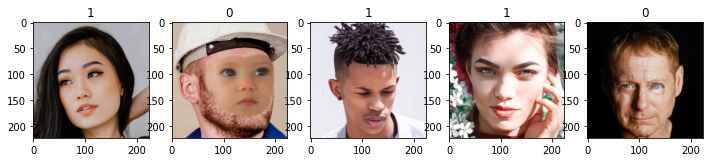

In [30]:
import matplotlib.pyplot as plt

itr = iter(train_loader)
batch = next(itr)

_, axs = plt.subplots(1, 5, figsize=(12, 12))
axs = axs.flatten()
for img,label,ax in zip(batch[0][:5],batch[1][:5],axs):
    ax.set_title(label.item())
    ax.imshow(img.permute(1,2,0))
plt.show()

### **Build CNN**

While we can build our own architecture, it is more common to finetune one of the more common architectures as we don't have alot of data. We will choose Resnet50 as it is popular in Computer Vision and therefore would allow us to create a more realistic benchmark.

In [ ]:
import torch.nn as nn
model = models.resnet50(pretrained=True)
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
print(model)


### **Training Loop**

In [ ]:
from tqdm.notebook import tqdm
import torch.nn as nn

model.to('cuda')
model.train()
final_results = []
final_labels = []
training_losses = []

ceLoss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
for epoch in tqdm(range(10)):
    total_loss = 0
    total_correct = 0
    for data in tqdm(train_loader): # Get Batch
        optimizer.zero_grad()

        batch = torch.tensor(data[0], dtype=torch.float32).to("cuda")

        label = torch.tensor(data[1]).to("cuda")
        
        preds = model(batch) # Pass Batch n
        loss = ceLoss(preds, label) # Calculate Loss
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()

        for j,k in zip (preds,label.tolist()):
            if(torch.argmax(j)==k):
              total_correct+=1
            final_results.append(torch.argmax(j).item())
            final_labels.append(k)

    training_losses.append(total_loss)

    print("epoch", epoch, "total_correct:", total_correct, "loss:", total_loss)
    

Visualize Training Results

In [ ]:
import matplotlib.pyplot as plt
plt.plot(training_losses,label="training loss")
plt.legend(loc="upper left")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(final_labels, final_results)
# Run helper methods below before procceding
plot_confusion_matrix(cm, classes={0,1},title='Confusion matrix')
plot_roc(final_results, final_labels)

### **Test Deep Fake Model**

In [ ]:
from tqdm.notebook import tqdm
test_correct = 0
final_results = []
final_labels = []
model.eval()
for data in tqdm(test_loader): # Get Batch

        batch = torch.tensor(data[0], dtype=torch.float32).to("cuda")

        label = torch.tensor(data[1]).to("cuda")
        
        preds = model(batch) # Pass Batch n

        for j,k in zip (preds,label.tolist()):
            if(torch.argmax(j)==k):
              test_correct+=1
            final_results.append(torch.argmax(j).item())
            final_labels.append(k)

val_acc = test_correct/(len(test_loader)*32)*100
print("Test Accuracy:", val_acc,"%")  

Print Confusion Matrix and ROC Curve

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(final_labels, final_results)
# Run helper methods below before procceding
plot_confusion_matrix(cm, classes={0,1},title='Confusion matrix')
plot_roc(final_labels, final_results)

### **Save Model**

In [ ]:
torch.save(network,"deepFakeModel.pth")

### **Load Faces of people of different races**

For this part of the evaluation we are going to use the UTKFace dataset which has labels from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

In [ ]:
def get_img_label(imgpath):
  label = imgpath.split("_")
  return label[2]

In [ ]:
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms


class race_face_data(Dataset):

    def __init__(self, root_dir = '/content/drive/My Drive/Pytorch Summer Hackathon/UTKFace/', transform=None):
      self.label = []
      self.dataArray = []

      for img in tqdm(os.listdir(root_dir)):
          label = get_img_label(img)
          self.label.append(label)
          img = Image.open(root_dir+img)
          trans = transforms.ToPILImage()
          trans1 = transforms.ToTensor()
          data = trans(trans1(img))
          if transform != None:
            data = transform(data)
          self.dataArray.append(data)
          
        
    def __len__(self):
        return len(self.dataArray)

    def __getitem__(self, idx):
        sample = {'data': self.dataArray[idx], 'label': self.label[idx], 'fake': 0}

        return sample

In [ ]:
from torchvision import transforms
trans = transforms.Compose([transforms.Resize(224),transforms.ToTensor()])
adv_data_loader = torch.utils.data.DataLoader(race_face_data(transform=trans), batch_size=32)

### **Visualize Data and Distribution**

Example Images

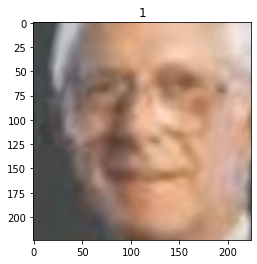

In [ ]:
import matplotlib.pyplot as plt

itr = iter(adv_data_loader)
batch = next(itr)

_, axs = plt.subplots(1, 5, figsize=(12, 12))
axs = axs.flatten()
for img,label,ax in zip(batch.get("data")[:5],batch.get("label")[:5],axs):
    ax.set_title(label.item())
    ax.imshow(img.permute(1,2,0))
plt.show()

### **Test Deepfake model with faces of different races**

In [ ]:
from tqdm.notebook import tqdm
test_correct = 0
final_results = []
final_labels = []
model.eval()
race_total = {0:0, 1:0, 2:0, 3:0, 4:0}
race_result = {0:0, 1:0, 2:0, 3:0, 4:0}
for data in tqdm(adv_data_loader): # Get Batch

        batch = torch.tensor(data.get("data"), dtype=torch.float32).to("cuda")

        label = torch.tensor(data.get("fake")).to("cuda")
        
        preds = model(batch) # Pass Batch n

        for j,k,l in zip (preds,label.tolist(),data.get("label")):
            if(torch.argmax(j)==k):
              test_correct+=1
              race_result.update(int(l),race_result.get(int(l))+1)
            race_total.update(int(l),race_total.get(int(l))+1)
            final_results.append(torch.argmax(j).item())
            final_labels.append(k)

val_acc = test_correct/(len(test_loader)*32)*100
print("Test Accuracy:", val_acc,"%")  

### **Visualize Results**

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
races = ['White', 'African-American', 'Asian', 'Indian', 'Other(Hispanic, Latino, Middle Eastern)']

acc = [(race_result.get(0)/race_total.get(0)*100),(race_result.get(1)/race_total.get(1)*100),(race_result.get(2)/race_total.get(2)*100)
              ,(race_result.get(3)/race_total.get(3)*100)
              ,(race_result.get(4)/race_total.get(4)*100)]

ax.bar(races,acc)
plt.show()

### **Helper Methods**

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap,aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)  
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.autoscale()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.figure()
    plt.show()
    

In [ ]:
import sklearn as sk
def plot_roc(truth, result):
  fpr, tpr, threshold = sk.metrics.roc_curve(truth, result)
  roc_auc = sk.metrics.auc(fpr, tpr)
  import matplotlib.pyplot as plt
  plt.title('ROC CURVE')
  plt.plot(fpr, tpr, 'blue', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate',)
  plt.xlabel('False Positive Rate')
  plt.figure()
  plt.show()